In [4]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt  
import numpy as np  
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  
import squarify
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


# 1.Overview of Data

In [6]:
data = pd.read_excel('data.xlsx')

In [7]:
data.rename(columns={
    'شماره مشتری': 'CID', 
    'تاریخ': 'date',
    'نام کالا': 'stock_name'
}, inplace=True)


In [6]:
data

,CID,date,stock_code,stock_name,quantity,unit_price
0,224356,12/11/2018,5585,دلستر خانواده,4.0,30000
1,224356,12/11/2018,5586,دلستر قوطی,4.0,30000
2,224356,12/16/2018,5370,شیر 250 cc,4.0,14000
3,224356,12/23/2018,3531,شیر قهوه موکا,2.0,14000
4,224356,12/23/2018,8596,آب پرتقال 250 cc,3.0,14000
...,...,...,...,...,...,...
412248,49332232,12/17/2019,3531,شیر قهوه موکا,0.0,14000
412249,49332232,12/17/2019,8596,آب پرتقال 250 cc,6.0,14000
412250,49332232,12/17/2019,8775,آب آلبالو 250 cc,6.0,14000
412251,49332232,12/21/2019,3531,شیر قهوه موکا,-1.0,14000


We have to subtract the obtained date from today's date

# 2.RFM Segmentation

RFM analysis helps in segmenting customers into different categories based on their scores.
RFM (Recency, Frequency, Monetary) analysis is a marketing technique used to quantify and evaluate a customer's value based on their purchasing behavior. The RFM model is based on three key factors:
- **Recency (R)**: How recently a customer made a purchase.
- **Frequency (F)**: How often a customer makes a purchase.
- **Monetary (M)**: How much money a customer spends on purchases.


In [22]:
#Recency (R)
data['date'] = pd.to_datetime(data['date'])  
max_date=data.date.max()
R = data.groupby('CID').agg({'date': 'max'})
R['date']=R['date'].apply(lambda x: (max_date - x).days + 1)

#Frequency (F)
F= data.groupby(["CID"]).agg({"date":"nunique"})

#Monetary (M)
data['total_price']= data.quantity * data.unit_price
M = data.groupby('CID').agg({'total_price': 'sum'})

#RFM 
RFM = pd.concat([R, F, M], axis=1)
RFM.columns=['R', 'F', 'M']
RFM.head()


,R,F,M
CID,,,
224356,8,19,1094000.0
276154,1,13,826000.0
279696,13,35,2850400.0
1301753,5,143,46196800.0
1393653,7,87,9725600.0


In [29]:
def plot_3d(RFM):
    R = RFM['R'].values  
    F = RFM['F'].values  
    M = RFM['M'].values  

    # Create a new 3D plot  
    fig = plt.figure(figsize=(10, 7))  
    ax = fig.add_subplot(111, projection='3d')  

    # Scatter plot with color mapping based on a category, size and alpha values  
    sc = ax.scatter(R, F, M, cmap='viridis', s=50, alpha=0.7)  

    # Add color bar  
    plt.colorbar(sc, label='Category')  

    # Set labels  
    ax.set_xlabel('Recency (R)')  
    ax.set_ylabel('Frequency (F)')  
    ax.set_zlabel('Monetary (M)')  

    # Set title  
    ax.set_title('3D Scatter Plot of RFM Analysis')  

    # Customize view angle  
    ax.view_init(elev=20, azim=30)  

    # Add grid  
    ax.grid(True)  

    # Show the plot  
    plt.show()

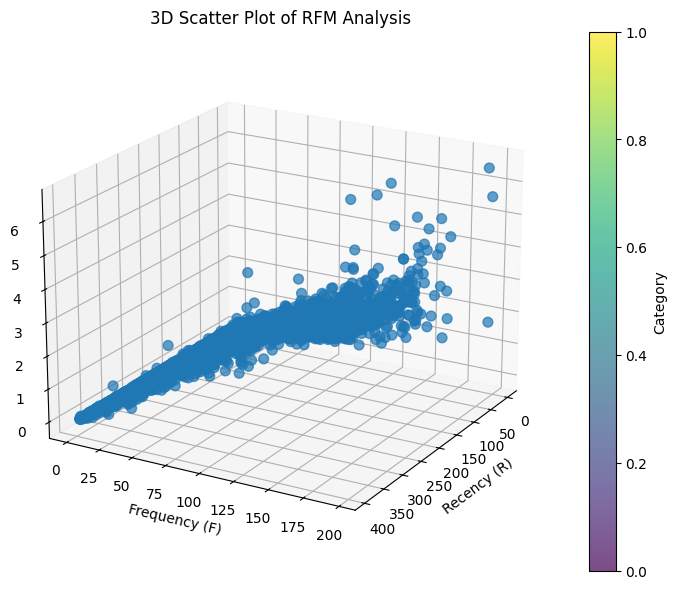

In [32]:
plot_3d(RFM)

#### Average Order Value (AOV) calculate the average monetary value per purchase for each customer.

In [9]:
RFM['A']=RFM['M']/RFM['F']

In [10]:
RFM['M']=RFM['A']
RFM.drop('A', axis=1, inplace=True)

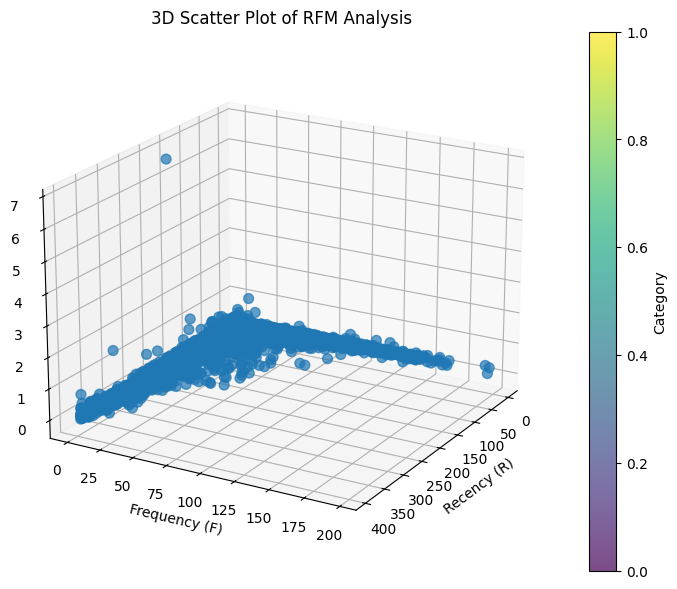

In [35]:
plot_3d(RFM)

# 3.outlier detection 

In [11]:
lab=IsolationForest(contamination=0.015).fit_predict(RFM)
np.unique(lab, return_counts=True)

(array([-1,  1]), array([ 137, 8960], dtype=int64))

We have 137  negative value that show outliers so we need to seprate from each other.

In [12]:
RFM['outlier'] = lab
outliers=RFM[RFM.outlier == -1].drop('outlier', axis=1)
inliers=RFM[RFM.outlier == 1].drop('outlier', axis=1)

## 4.display outliers and inliers 

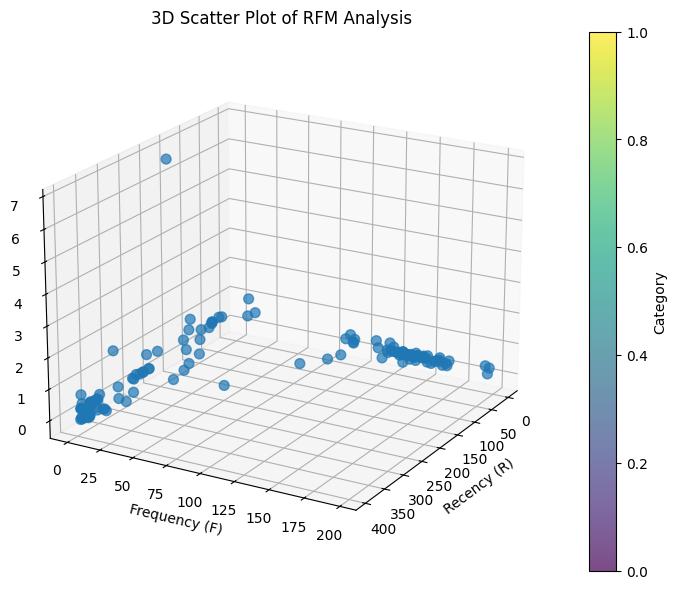

In [38]:
plot_3d(outliers)

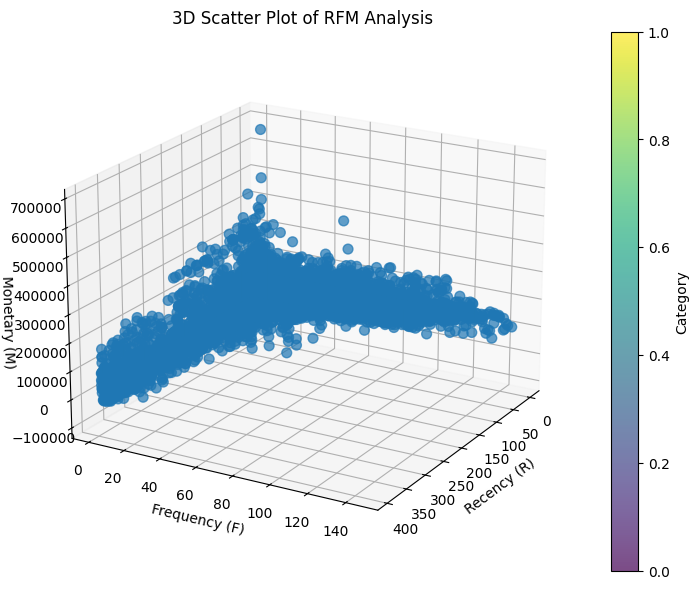

In [40]:
plot_3d(inliers)

In [52]:
inliers.corr()

,R,F,M,A
R,1.000000,-0.337538,-0.282612,-0.131900
F,-0.337538,1.000000,0.900532,0.309946
M,-0.282612,0.900532,1.000000,0.480359
A,-0.131900,0.309946,0.480359,1.000000


## display data distribution

array([[<Axes: title={'center': 'R'}>, <Axes: title={'center': 'F'}>],
       [<Axes: title={'center': 'M'}>, <Axes: >]], dtype=object)

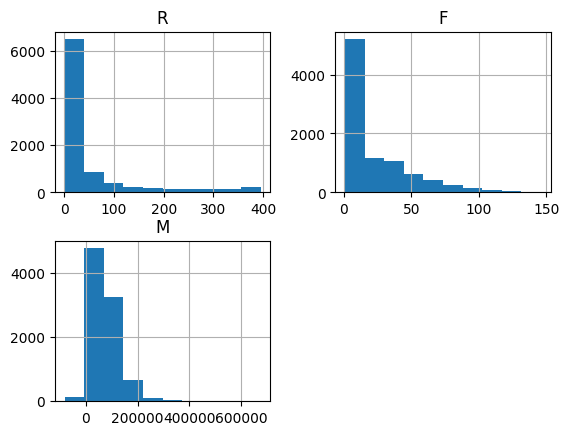

In [41]:
inliers.hist()

To address the skewness in our data, applying logarithmic transformation is indeed a straightforward approach. For increased efficiency, we can outline a more streamlined process by comparing two methods for handling skewed data.

- **Method 1:** Logarithmic Transformation
- **Method 2:** PowerTransformer


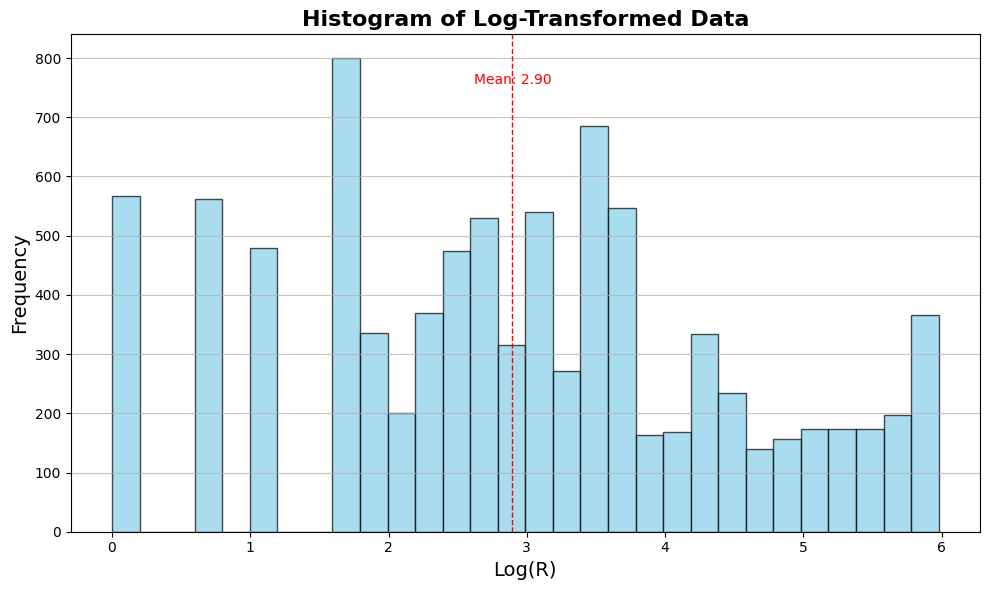

In [56]:

d = np.log(inliers['R'])  

# Create the histogram  
plt.figure(figsize=(10, 6))  # Increase the figure size for better visibility  
plt.hist(d, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Custom colors and transparency  

# Adding titles and labels  
plt.title('Histogram of Log-Transformed Data', fontsize=16, fontweight='bold')  
plt.xlabel('Log(R)', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  

# Adding gridlines for better readability  
plt.grid(axis='y', alpha=0.75)  

# Adding a vertical line for mean  
mean_log = np.mean(d)  
plt.axvline(mean_log, color='red', linestyle='dashed', linewidth=1)  
plt.text(mean_log, plt.ylim()[1]*0.9, f'Mean: {mean_log:.2f}', color='red', ha='center')  

# Show the plot  
plt.tight_layout()  # Adjust layout to prevent clipping  
plt.show()

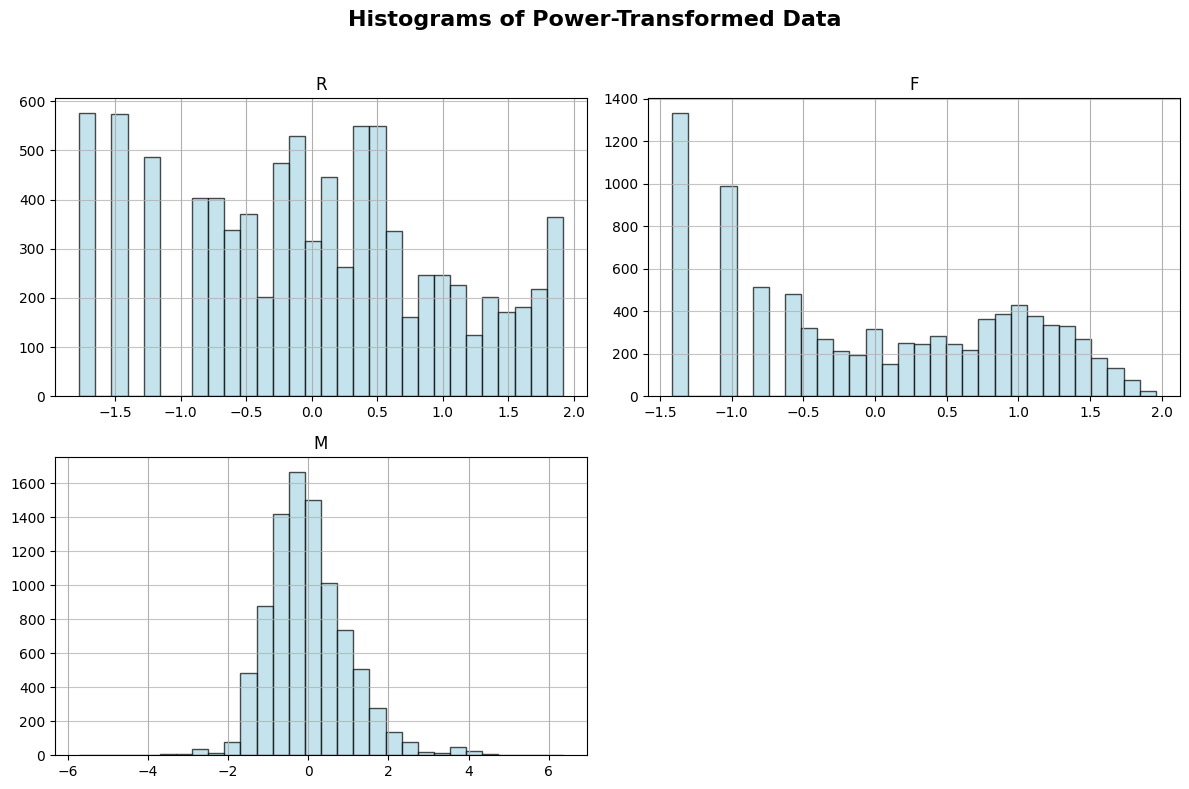

In [13]:
# Applying Power Transformation  
pt = PowerTransformer()  
transformed_data = pt.fit_transform(inliers)  
df_transformed= pd.DataFrame(transformed_data, columns=inliers.columns,index=inliers.index)

# Plotting histograms for each transformed column  
df_transformed.hist(bins=30, figsize=(12, 8), color='lightblue', edgecolor='black', alpha=0.7)  

# Adjusting layout and aesthetics  
plt.suptitle('Histograms of Power-Transformed Data', fontsize=16, fontweight='bold')  
plt.xlabel('Value', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  

# Adding gridlines  
for ax in plt.gcf().get_axes():  
    ax.grid(axis='y', alpha=0.75)  

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title  
plt.show()

# 5.Kmeans

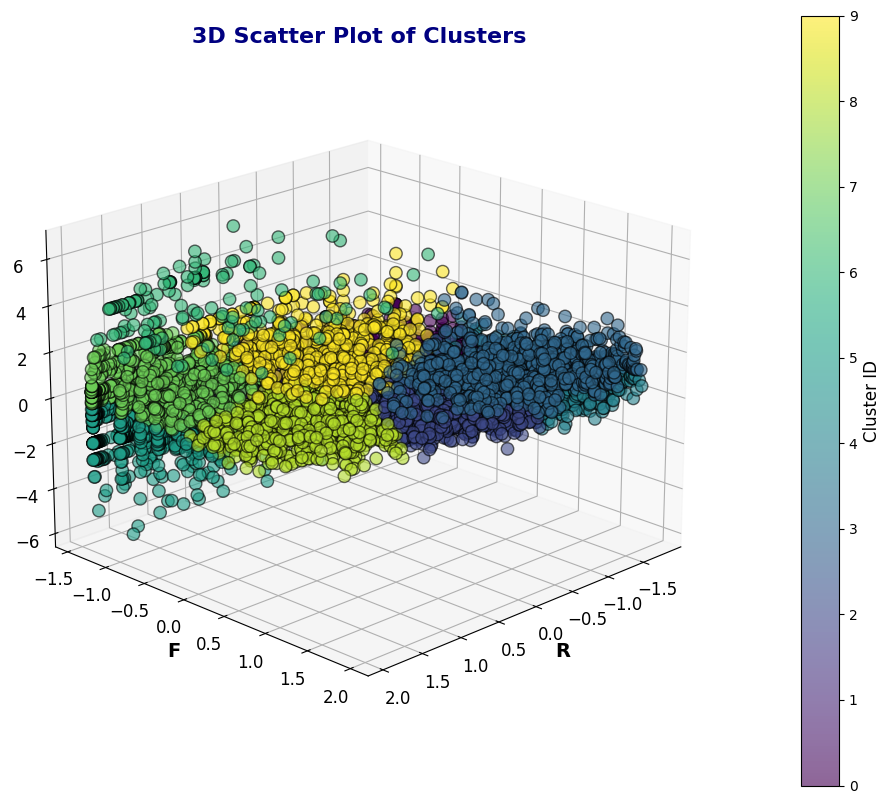

In [24]:
def plot3d(data, x, y, z, colors):  
    fig = plt.figure(figsize=(12, 10))  
    ax = fig.add_subplot(111, projection='3d')  
    
    # Creating a scatter plot with improved aesthetics  
    scatter = ax.scatter(data[x], data[y], data[z], c=colors, cmap='viridis', s=80, alpha=0.6, edgecolor='k')  
    
    # Setting labels with enhanced font size  
    ax.set_xlabel(x, fontsize=14, fontweight='bold')  
    ax.set_ylabel(y, fontsize=14, fontweight='bold')  
    ax.set_zlabel(z, fontsize=14, fontweight='bold')  

    # Adding a title with enhanced styling  
    ax.set_title('3D Scatter Plot of Clusters', fontsize=16, fontweight='bold', color='navy')  
    
    # Adding a color bar for reference  
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)  
    cbar.set_label('Cluster ID', fontsize=12)  
    
    # Customizing tick parameters for better readability  
    ax.tick_params(axis='both', which='major', labelsize=12)  
    
    # Adjusting the viewing angle for better perspective  
    ax.view_init(elev=20, azim=45)  
    
    plt.show()  

# KMeans Clustering  
kmeans = KMeans(n_clusters=10, random_state=42)  
clusters = kmeans.fit_predict(df_transformed)  

# Call the plot function to display the enhanced 3D scatter plot  
plot3d(df_transformed, 'R', 'F', 'M', clusters) 

## elbow method
To find the optimal value of k:

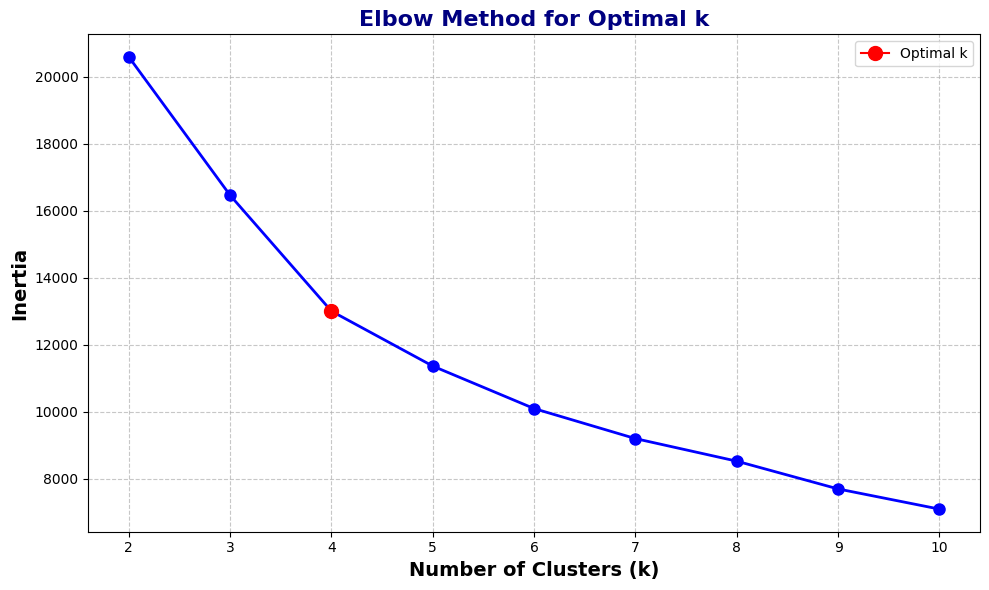

In [71]:
elbow = []  
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, random_state=42)  
    clusters = kmeans.fit_predict(df)  
    elbow.append(kmeans.inertia_)  

# Plotting the elbow curve  
plt.figure(figsize=(10, 6))  
plt.plot(range(2, 11), elbow, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)  

# Highlight the elbow point  
optimal_k = 4  # Replace with the inferred optimal 'k' if necessary  
plt.plot(optimal_k, elbow[optimal_k - 2], marker='o', markersize=10, color='r', label='Optimal k')  

# Adding grid, title, and labels  
plt.title('Elbow Method for Optimal k', fontsize=16, fontweight='bold', color='navy')  
plt.xlabel('Number of Clusters (k)', fontsize=14, fontweight='bold')  
plt.ylabel('Inertia', fontsize=14, fontweight='bold')  
plt.xticks(range(2, 11))  # Set x-ticks to integers from 2 to 10  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.legend()  
plt.tight_layout()    
plt.show()  

# Data Visualization: Snake Plot and Treemap

in this section we visualize customer segments using a snake plot and a treemap.snake plot is a way to visualize how RFM (Recency, Frequency, Monetary) metrics change across different customer segments or groups.  
## Snake Plot

In [15]:
df_transformed['cluster']=clusters
datamart_melt = pd.melt(df_transformed.reset_index(),
                        id_vars=['cluster'],       
                        value_vars=['R', 'F', 'M'],  
                        var_name='Attribute',                  
                        value_name='Value')


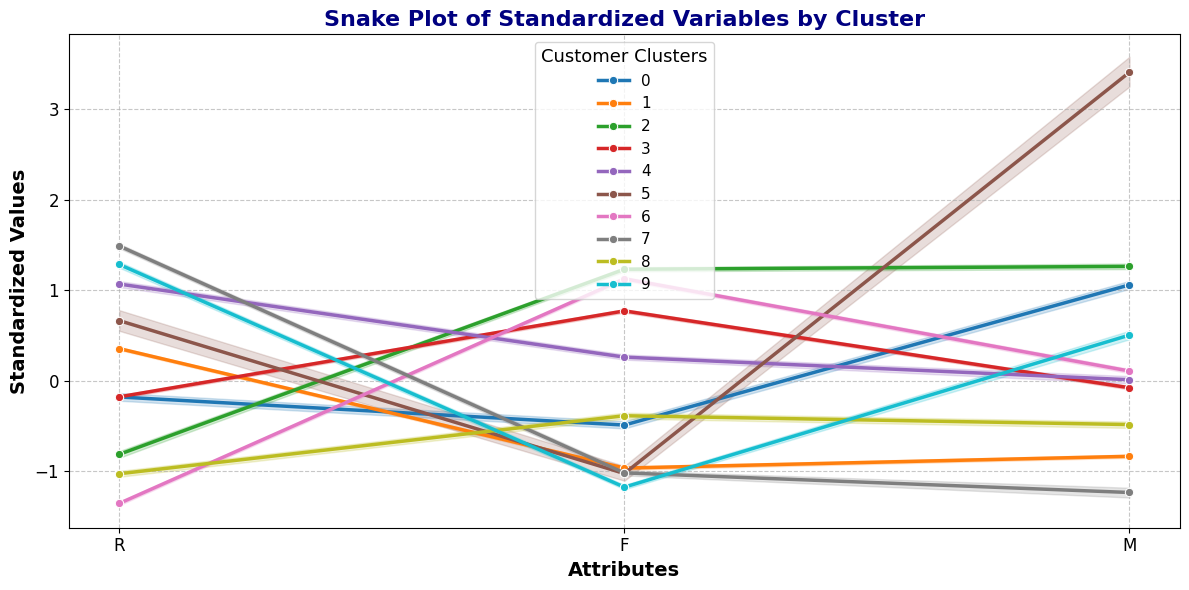

In [62]:

plt.figure(figsize=(12, 6))  
sns.lineplot(x="Attribute", y="Value", hue='cluster', data=datamart_melt,   
             marker='o', palette='tab10', linewidth=2.5)  

# Enhance plot for interpretability  
plt.title('Snake Plot of Standardized Variables by Cluster', fontsize=16, fontweight='bold', color='navy')  
plt.xlabel('Attributes', fontsize=14, fontweight='bold')  
plt.ylabel('Standardized Values', fontsize=14, fontweight='bold')  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.legend(title='Customer Clusters', title_fontsize='13', fontsize='11')  
plt.tight_layout()  # Adjust layout for better fit  

# Annotate values on the lines for better interpretability  
for i in range(datamart_melt['cluster'].nunique()):  
    cluster_data = datamart_melt[datamart_melt['cluster'] == f'cluster {i + 1}']  
    for j in range(len(cluster_data)):  
        plt.text(x=cluster_data['Attribute'].iloc[j],   
                 y=cluster_data['Value'].iloc[j],   
                 s=round(cluster_data['Value'].iloc[j], 2),   
                 fontsize=10,   
                 ha='center',   
                 va='bottom')  

plt.show()  

**Interpration of snake plot**

---
**From the snake plot, we should look for:**
- **1.** Clusters that stand out positively in `Frequency` and `Monetary`,scores (suggests loyal, high-value customers).
- **2.** Clusters that have `high Recency` values.

**If we find any cluster fitting these characteristics, that would indicate they are a good candidate for `Sending SMS` messages.**

- **The `green and pink clusters` are `Champions` segments of customer :**
- Champions: Recent, frequent, and high-value buyers.(2,6)



- **The ` purple and red clusters` are  `Loyal `  segments of customer :**
- Loyal Customers: Frequent buyers who are less recent but still high-value.(3,4)



- **The `yellow cluster` is a `Potential Loyalists`  segment of customer :**
- Potential Loyalists: Recent and high-value but less frequent. (8)



- **The `light blue and Brown clusters` are  `At Risk`  segments of customer :**
- At Risk: Former high-value customers who haven't purchased recently.(5,9)



- **The `dark blue cluster` is a `Need Attention`  segment of customer :**
- Need Attention: Recent and moderate frequency and value buyers.(0)



- **The `orange cluster` is a `Hibernating`  segment of customer :**
- Hibernating: Low-frequency and low-value buyers who haven't purchased recently.(1)



- **The ` gray cluster ` is a `Lost`  segment of customer :**
- Lost: Low-value and low-frequency buyers who haven't purchased for a long time.(7)

### Show the result:

In [151]:
def return_segment(n):
    df_transformed[df_transformed["cluster"] == n].to_csv("customer.csv")
    return df_transformed[df_transformed["cluster"] == n]

In [152]:
return_segment(3)

,R,F,M,cluster
CID,,,,
4701479,0.675912,-1.417829,3.609053,3
4701480,-0.146608,0.020672,2.461564,3
4701487,1.036086,-1.417829,2.437955,3
4701701,1.539364,-1.417829,2.437955,3
4702023,0.096485,0.211810,2.259700,3
...,...,...,...,...
44567947,-0.146608,-0.472944,3.516007,3
44567963,0.190865,-1.061354,1.844787,3
44567967,-0.197402,-1.061354,2.908596,3


## Treemap 

In [16]:
cluster_summary = df_transformed['cluster'].value_counts().reset_index()
cluster_summary.columns = ['cluster', 'size']


In [20]:
cluster_summary

,cluster,size
0,1,1702
1,4,1611
2,0,997
3,9,899
4,6,840
5,2,831
6,5,687
7,7,665
8,3,575
9,8,153


In [19]:

def plot_treemap(df, label_col, size_col):
    """
    Plots an interactive treemap of different clusters.

    Parameters:
    - df (DataFrame): DataFrame containing cluster information.
    - label_col (str): Column name for cluster labels.
    - size_col (str): Column name for cluster sizes.
    """
    fig = px.treemap(
        df,
        path=[label_col],
        values=size_col,
        color=label_col,
        color_continuous_scale='Blues',
        title='Treemap of Customer Clusters'
    )
    fig.update_layout(
        title_font_size=16,
        title_font_color='navy',
        margin=dict(t=50, l=25, r=25, b=25)
    )
    fig.show()

# Example usage
plot_treemap(cluster_summary, 'cluster', 'size')